In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import shutil
import keras_tuner as kt
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
TICKER = "GOTO"
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,338.0,354.0,334.0,354.0,840928300,0.086957
2022-07-12,330.0,338.0,330.0,338.0,802215500,0.127820
2022-07-13,324.0,330.0,320.0,330.0,870421000,-0.022727
2022-07-14,332.0,336.0,320.0,324.0,786358600,-0.090032
2022-07-15,320.0,336.0,320.0,332.0,998698500,-0.024390
...,...,...,...,...,...,...
2025-07-25,58.0,59.0,57.0,59.0,5090425000,-0.165906
2025-07-28,59.0,60.0,58.0,58.0,3567335000,-0.139048
2025-07-29,59.0,60.0,58.0,59.0,1423009300,-0.040984


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-07-11 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           732 non-null    float64
 1   High            732 non-null    float64
 2   Low             732 non-null    float64
 3   Open            732 non-null    float64
 4   Volume          732 non-null    int64  
 5   nilai_sentimen  732 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [ ]:
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,338.0,354.0,334.0,354.0,840928300,0.086957
2022-07-12,330.0,338.0,330.0,338.0,802215500,0.127820
2022-07-13,324.0,330.0,320.0,330.0,870421000,-0.022727
2022-07-14,332.0,336.0,320.0,324.0,786358600,-0.090032
2022-07-15,320.0,336.0,320.0,332.0,998698500,-0.024390
...,...,...,...,...,...,...
2025-07-25,58.0,59.0,57.0,59.0,5090425000,-0.165906
2025-07-28,59.0,60.0,58.0,58.0,3567335000,-0.139048
2025-07-29,59.0,60.0,58.0,59.0,1423009300,-0.040984


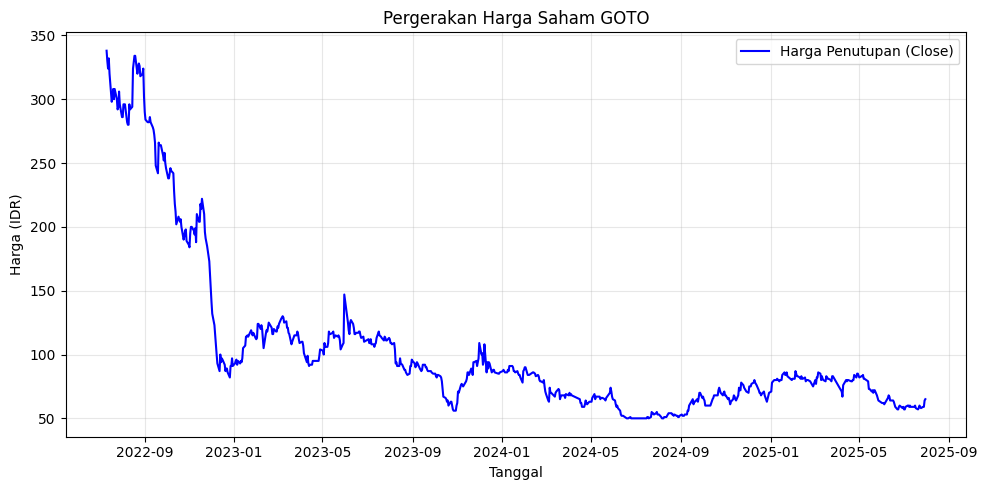

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,338.0,840928300,0.086957
2022-07-12,330.0,802215500,0.127820
2022-07-13,324.0,870421000,-0.022727
2022-07-14,332.0,786358600,-0.090032
2022-07-15,320.0,998698500,-0.024390
...,...,...,...
2025-07-25,58.0,5090425000,-0.165906
2025-07-28,59.0,3567335000,-0.139048
2025-07-29,59.0,1423009300,-0.040984


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
print("Train samples:", X_train.shape[0], "val samples:", X_val.shape[0])

Train samples: 520 val samples: 131


In [ ]:
joblib.dump(scaler, f"./data/{TICKER}/scaler_sentimen.pkl")

['./data/GOTO/scaler_sentimen.pkl']

## Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
## Reset/Ulang Tuning

# tuning_dir = f'model/{TICKER}/{TICKER}_lstm_tuning'

# if os.path.exists(tuning_dir):
#     shutil.rmtree(tuning_dir)

### persiapan

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
earlystop = callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

###LSTM

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('lstm_units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('lstm_units2', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.LSTM(hp_units1, return_sequences=True),
        layers.LSTM(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=30,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_lstm_tuning'
)

Reloading Tuner from model/GOTO/GOTO_lstm_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 30 Complete [00h 00m 07s]
val_root_mean_squared_error: 0.02679515816271305

Best val_root_mean_squared_error So Far: 0.0240571741014719
Total elapsed time: 00h 03m 52s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'lstm_units1': 32, 'lstm_units2': 112, 'dropout_rate': 0.1, 'dense_units': 48}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 112)            │        64,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         5,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,070 (297.15 KB)

 Trainable params: 76,070 (297.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 112)            │        64,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         5,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,070 (297.15 KB)

 Trainable params: 76,070 (297.15 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = lstm_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 5s - 214ms/step - loss: 0.0139 - root_mean_squared_error: 0.1181
Epoch 2/100
21/21 - 0s - 10ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696
Epoch 3/100
21/21 - 0s - 10ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608
Epoch 4/100
21/21 - 0s - 10ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582
Epoch 5/100
21/21 - 0s - 9ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556
Epoch 6/100
21/21 - 0s - 14ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547
Epoch 7/100
21/21 - 0s - 14ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532
Epoch 8/100
21/21 - 0s - 14ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530
Epoch 9/100
21/21 - 0s - 13ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532
Epoch 10/100
21/21 - 0s - 15ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528
Epoch 11/100
21/21 - 0s - 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513
Epoch 12/100
21/21 - 0s - 14ms/step - loss: 0.0026 - root_mean_squared_err

In [ ]:
eval_results = lstm_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.0002495852531865239, 0.015798266977071762]


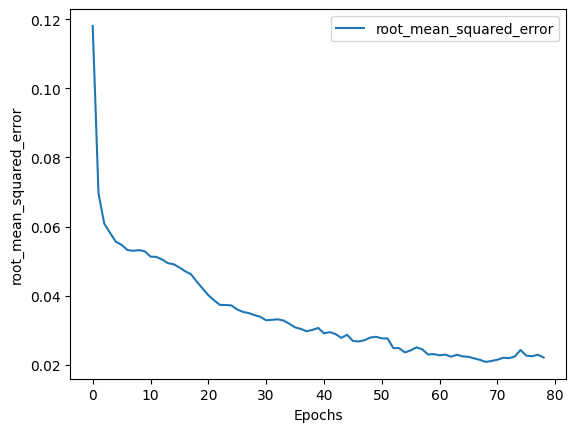

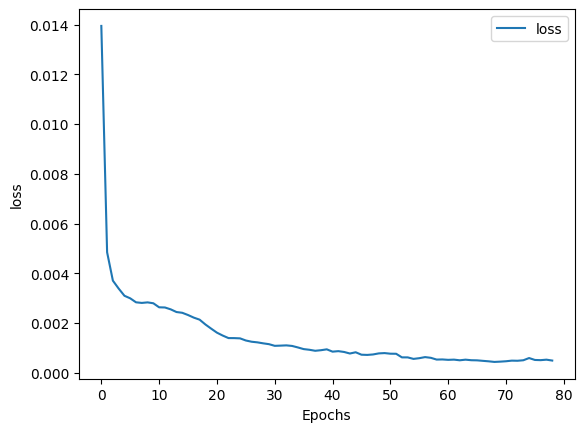

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = lstm_model.predict(X_train)
val_pred = lstm_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(lstm_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediksi 22 hari ke depan (close):
[56.69032943 56.91176403 56.73943692 56.97682583 56.86877733 55.43311584
 54.55731398 55.97432393 54.47654462 55.52319515 55.62452686 55.19038075
 54.73527908 55.72831547 55.63603354 56.4621743  57.6642288  57.99872279
 57.43157989 58.4526695  58.4853093  57.56661785]


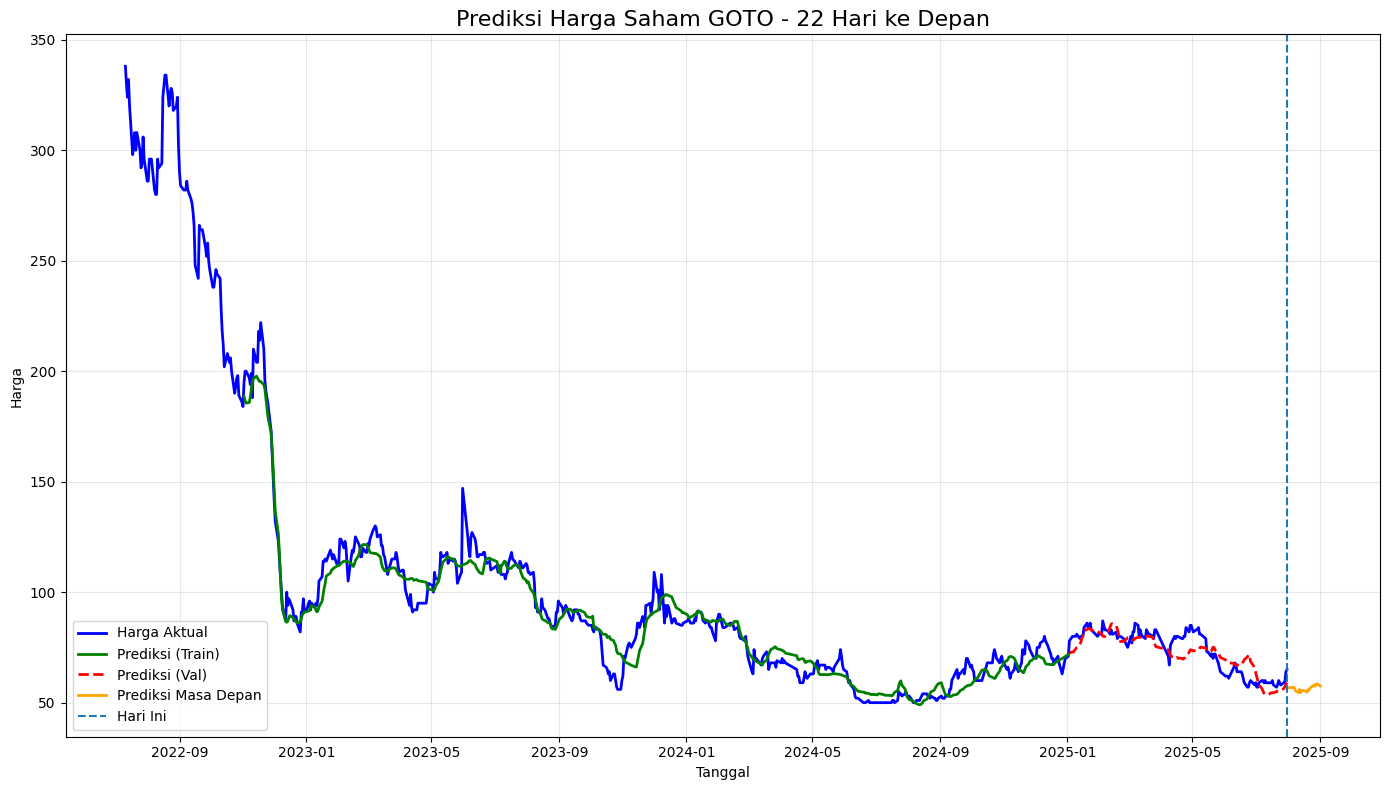

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
lstm_model.save(f"./model/{TICKER}/sentimen_lstm_model.keras")
lstm_model.save(f"./model/{TICKER}/sentimen_lstm_model.h5")

### BiLSTM

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('bilstm_units', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.Bidirectional(layers.LSTM(hp_units1, return_sequences=True)),
        layers.LSTM(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=50,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_bilstm_tuning'
)

Reloading Tuner from model/GOTO/GOTO_bilstm_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 50 Complete [00h 00m 12s]
val_root_mean_squared_error: 0.02233048714697361

Best val_root_mean_squared_error So Far: 0.02233048714697361
Total elapsed time: 00h 19m 39s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'bilstm_units': 128, 'lstm_units': 64, 'dropout_rate': 0.5, 'dense_units': 48}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,542 (865.40 KB)

 Trainable params: 221,542 (865.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bilstm_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 60, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,542 (865.40 KB)

 Trainable params: 221,542 (865.40 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = bilstm_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 3s - 147ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278
Epoch 2/100
21/21 - 0s - 12ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777
Epoch 3/100
21/21 - 0s - 12ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671
Epoch 4/100
21/21 - 0s - 13ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619
Epoch 5/100
21/21 - 0s - 12ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 6/100
21/21 - 0s - 12ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603
Epoch 7/100
21/21 - 0s - 12ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590
Epoch 8/100
21/21 - 0s - 14ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572
Epoch 9/100
21/21 - 0s - 12ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544
Epoch 10/100
21/21 - 0s - 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520
Epoch 11/100
21/21 - 0s - 12ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533
Epoch 12/100
21/21 - 0s - 12ms/step - loss: 0.0027 - root_mean_squared_er

In [ ]:
eval_results = bilstm_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.0006856240215711296, 0.02618442289531231]


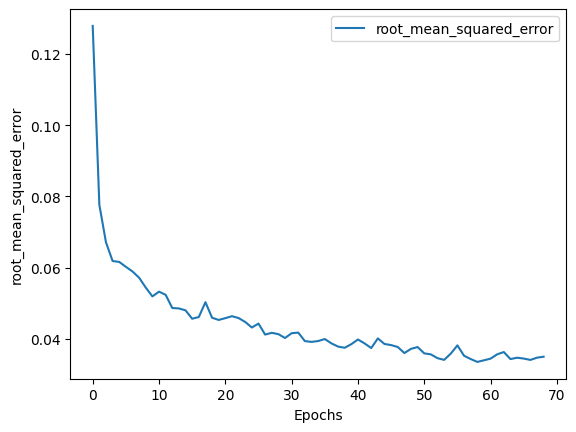

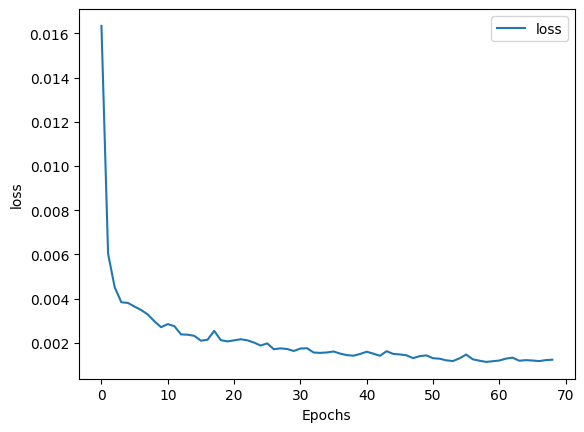

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = bilstm_model.predict(X_train)
val_pred = bilstm_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(bilstm_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediksi 22 hari ke depan (close):
[59.95402741 60.04322052 61.58158004 60.18371141 60.77119565 60.80322337
 61.57744837 60.61566293 61.3154223  60.79139376 60.74322987 60.39059877
 62.60250604 62.12893414 61.41745138 61.34981036 61.24333203 60.42961848
 60.45296335 61.32978177 62.88378072 62.14727509]


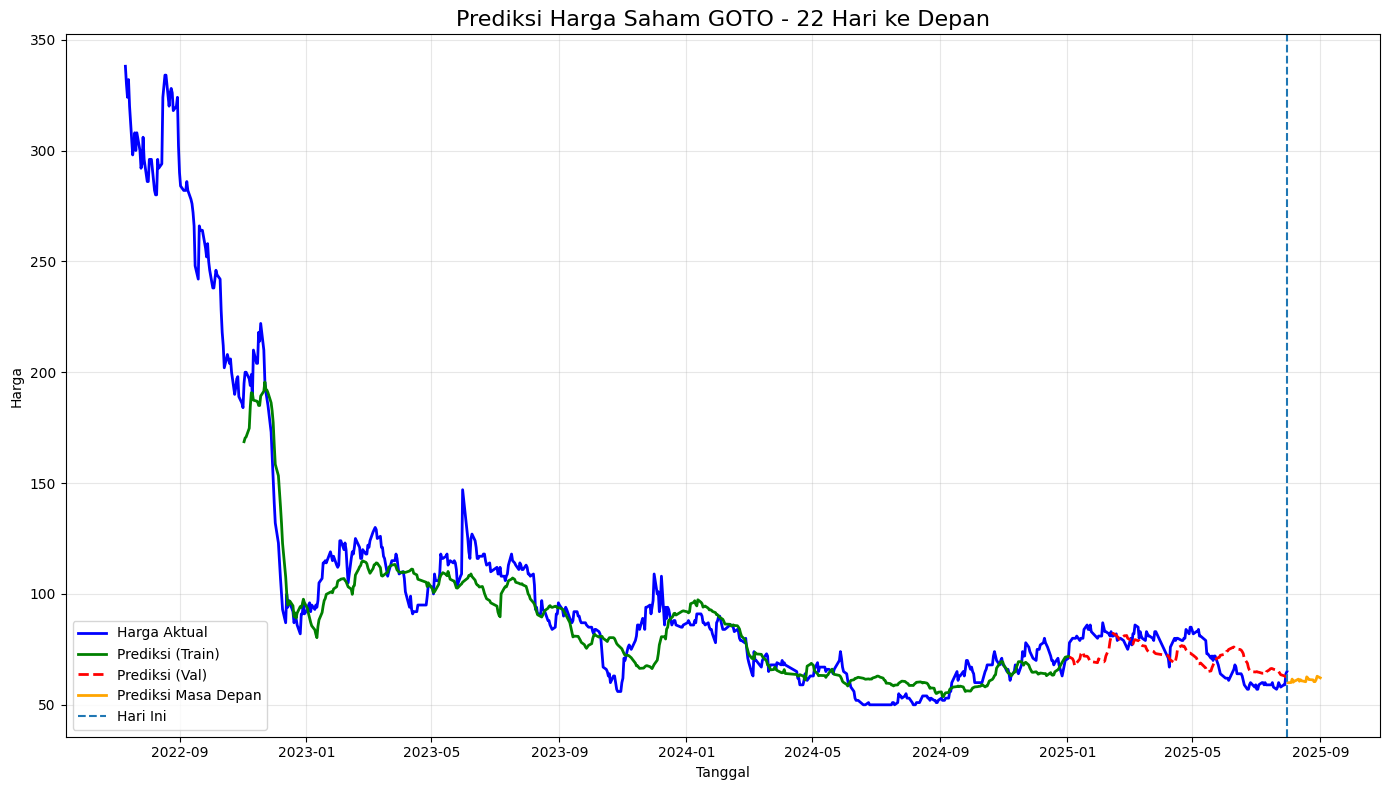

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
bilstm_model.save(f"./model/{TICKER}/sentimen_bilstm_model.keras")
bilstm_model.save(f"./model/{TICKER}/sentimen_bilstm_model.h5")

### GRU

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('gru_units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('gru_units2', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.GRU(hp_units1, return_sequences=True),
        layers.GRU(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=30,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_gru_tuning'
)

Reloading Tuner from model/GOTO/GOTO_gru_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 30 Complete [00h 00m 09s]
val_root_mean_squared_error: 0.022805722430348396

Best val_root_mean_squared_error So Far: 0.02190512791275978
Total elapsed time: 00h 05m 10s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'gru_units1': 32, 'gru_units2': 48, 'dropout_rate': 0.2, 'dense_units': 16}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,518 (64.52 KB)

 Trainable params: 16,518 (64.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 48)             │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │           374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,518 (64.52 KB)

 Trainable params: 16,518 (64.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = gru_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 2s - 118ms/step - loss: 0.0206 - root_mean_squared_error: 0.1437
Epoch 2/100
21/21 - 1s - 29ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056
Epoch 3/100
21/21 - 1s - 26ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747
Epoch 4/100
21/21 - 0s - 11ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637
Epoch 5/100
21/21 - 0s - 10ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582
Epoch 6/100
21/21 - 0s - 9ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577
Epoch 7/100
21/21 - 0s - 9ms/step - loss: 0.0032 - root_mean_squared_error: 0.0570
Epoch 8/100
21/21 - 0s - 10ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568
Epoch 9/100
21/21 - 0s - 11ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547
Epoch 10/100
21/21 - 0s - 14ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547
Epoch 11/100
21/21 - 0s - 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517
Epoch 12/100
21/21 - 0s - 10ms/step - loss: 0.0027 - root_mean_squared_erro

In [ ]:
eval_results = gru_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.00045471536577679217, 0.021324055269360542]


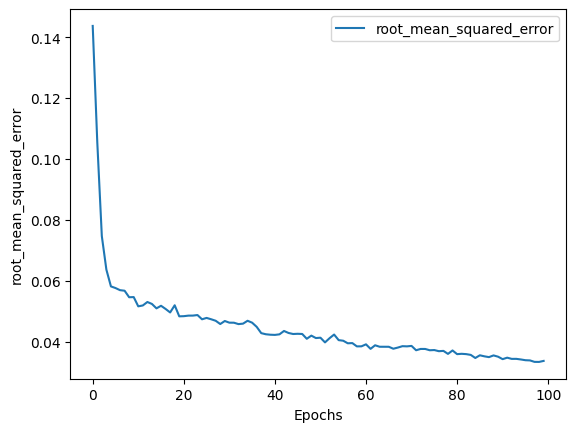

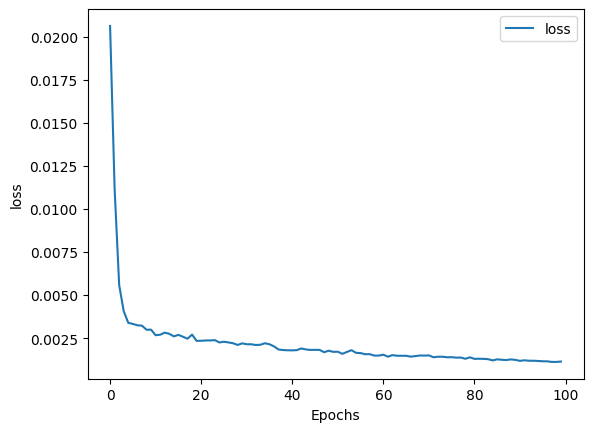

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = gru_model.predict(X_train)
val_pred = gru_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(gru_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi 22 hari ke depan (close):
[59.88669968 61.80096328 60.30009139 62.14152551 61.09161341 59.92539644
 59.88055634 61.06331933 60.09272766 58.56920934 59.87641931 61.65420032
 59.72504079 59.69235325 59.57425237 60.77800417 59.92744994 61.61798191
 62.46731949 61.88847733 63.12655067 60.97012222]


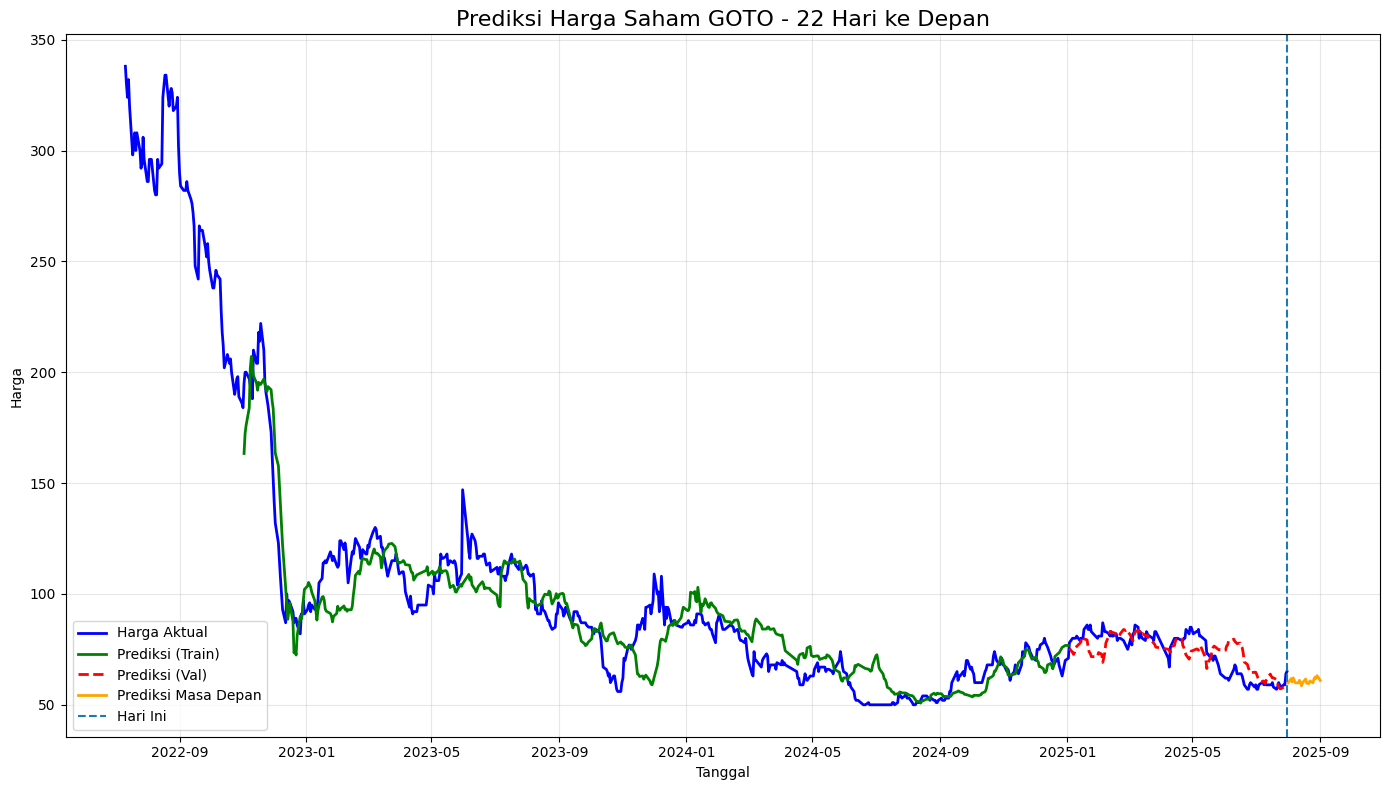

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
gru_model.save(f"./model/{TICKER}/sentimen_gru_model.keras")
gru_model.save(f"./model/{TICKER}/sentimen_gru_model.h5")